# Project 2: Advanced Lane Finding

In this notebook, we present the necessary steps to build a pipeline to identify lane lines in a video file. The notebook consists of 6 sub-sections, as per the instructions:

1. Compute the camera calibration matrix and distrotion coefficients given a set of chessboard images.

2. Apply a distortion correction to raw images.

3. Use color transforms, gradients, etc., to create a thresholded binary image.

4. Apply a perspective transform to rectify binary image ("birds-eye view").

5. Detect lane pixels and fit to find the lane boundary.

6. Determine the curvature of the lane and vehicle position with respect to center.

7. Warp the detected lane boundaries back onto the original image.

8. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

9. Process the video



### 0. Import the necessary modules

Here, we import the necessary packages and modules to run the code below. We use the aliases as in the lectures.

In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from aux_functions import *
import importlib
%matplotlib inline

### 1. Compute camera calibration


We start by identifying the corners on the maximum number of calibrating images possible, so that we obtain a 2d-3d mapping, leading to a robust calibration.

In [2]:
# Set the number of corners (nx,ny) to (9,6)
nx=9
ny=6

# The list containing the names of the files corresponding to the camera images
list_fnames=os.listdir('camera_cal/')

# The arrays to hold the parameters
initialpoints =[] # 3D points
targetpoints=[] # 2D points
c=0 #To count the number of succesful corner identifications
for file in list_fnames:
    file=os.path.join('camera_cal/',file)
    img=cv2.imread(file)
    initialp=np.zeros((nx*ny,3),np.float32)
    #Set the first two columns to x and y
    initialp[:,:2]=np.mgrid[0:9,0:6].T.reshape(-1,2)
    # Convert to grayscale and find the corners
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    if ret==True :
        targetpoints.append(corners)
        initialpoints.append(initialp)
        c+=1

print("The calibration of the camera will be performed using {} 3d-2d mappings.".format(c))


The calibration of the camera will be performed using 17 3d-2d mappings.


In the next line, we use the function cv2.calibrateCamera to calibrate the camera making use of the 17 mappings calculated above.

In [3]:
retval, cameraMatrix, distCoeffs, rvecs, tvecs=cv2.calibrateCamera(initialpoints, targetpoints,gray.shape[::-1],None,None)
print("Calibration is ready to test.")

Calibration is ready to test.


Let us then test the calibration by correcting the distortion on the first image in 'camera_cal'.

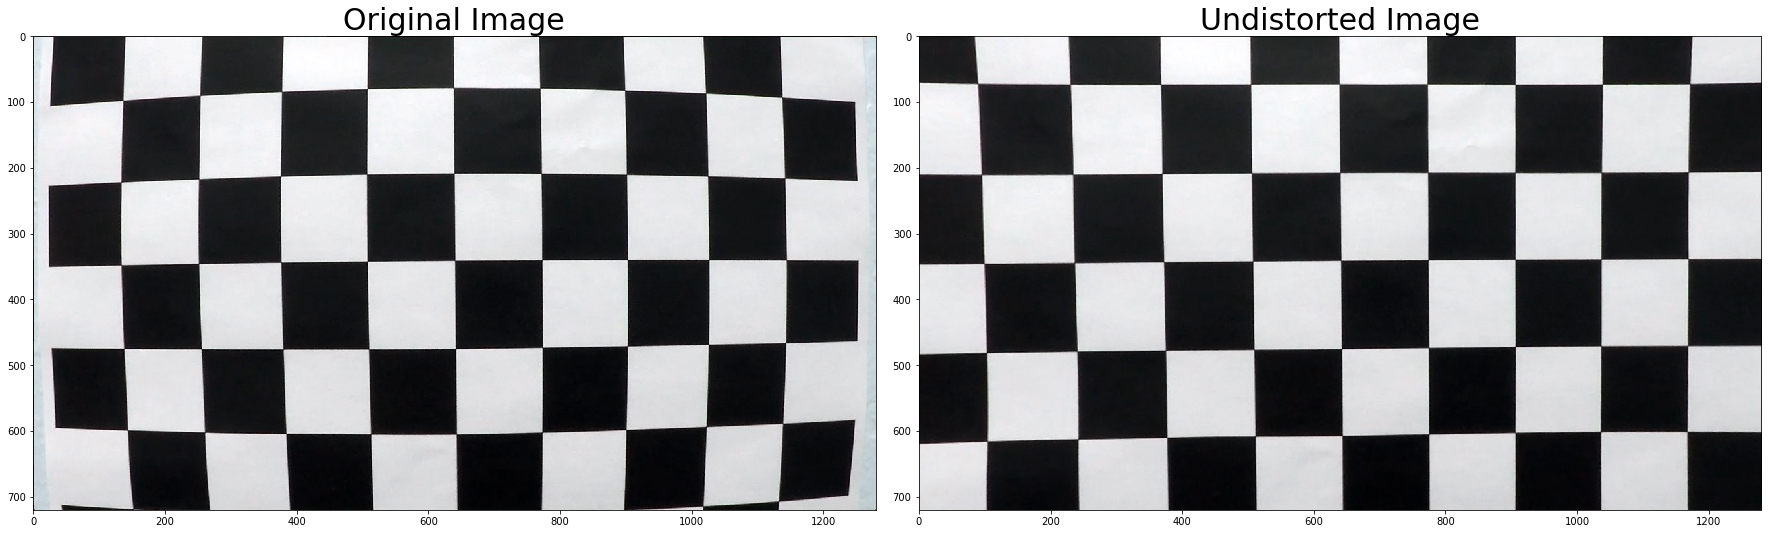

In [4]:
# Pick the first image for distortion correction
img=cv2.imread('camera_cal/calibration1.jpg')
undist=cv2.undistort(img,cameraMatrix,distCoeffs,None,cameraMatrix)

# Plot
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undist)
ax2.set_title('Undistorted Image', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.imsave('pipeline_images/original_undist.jpg', undist)



The distortion correction looks satisfactory. Next, we apply distortion correction to all the images in the folder 'camera_cal'.

### 2. Apply distortion correction to all raw images.

We apply the correction, and save the results in the 'images_output' folder.

In [5]:
path='output_images'
for el in list_fnames:
    file=os.path.join('camera_cal/',el)
    img=cv2.imread(file)
    undist=cv2.undistort(img,cameraMatrix,distCoeffs,None,cameraMatrix)
    file_sname= el[:-4]+ '_undistorted.jpg'
    plt.imsave(os.path.join(path,file_sname),undist)



We now move to creating a treshold binary image. For clarity, the function is defined in the module aux_functions.py.

### 3. Create threshold binary image using color space and gradient
We do this in two steps. The thresholds were obtained by trial and error.

We are using test6.jpg to test


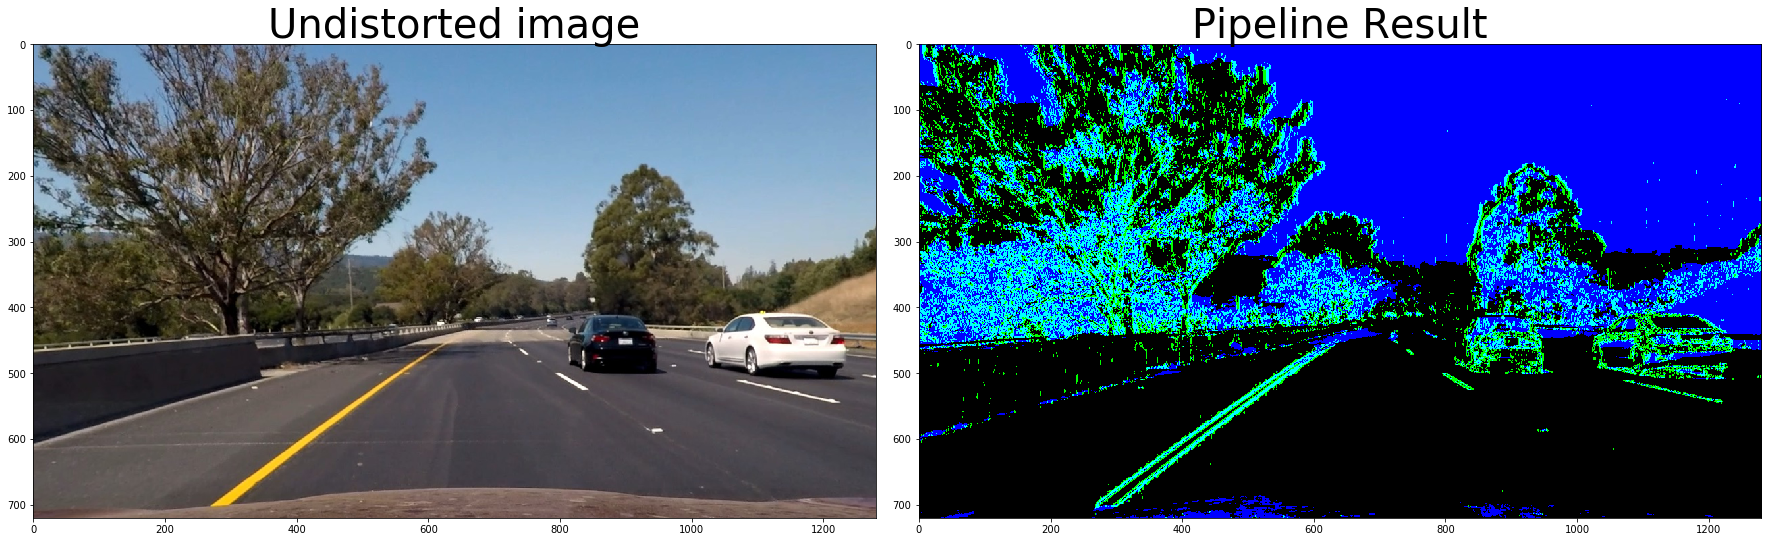

In [6]:
# We use the first image of test images
path='test_images/'
list_fnames=os.listdir(path)
image_test=mpimg.imread(os.path.join(path,list_fnames[0]))
print("We are using {} to test".format(list_fnames[0]))

# Undistort the image and apply the grad_color pipeline
image_test_und=cv2.undistort(image_test,cameraMatrix,distCoeffs,None,cameraMatrix)
result = pipeline_grad_color_thresh(image_test_und,s_thresh=(50, 180), sx_thresh=(10, 190))

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image_test_und)
ax1.set_title('Undistorted image', fontsize=40)
ax2.imshow(result)
ax2.set_title('Pipeline Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

#Save the images
plt.imsave('pipeline_images/test6_original.jpg', image_test)
plt.imsave('pipeline_images/test6_undistorted.jpg',image_test_und)
plt.imsave('pipeline_images/color_gradient.jpg', result)


We now convert the images to gray and plot the resulting output.

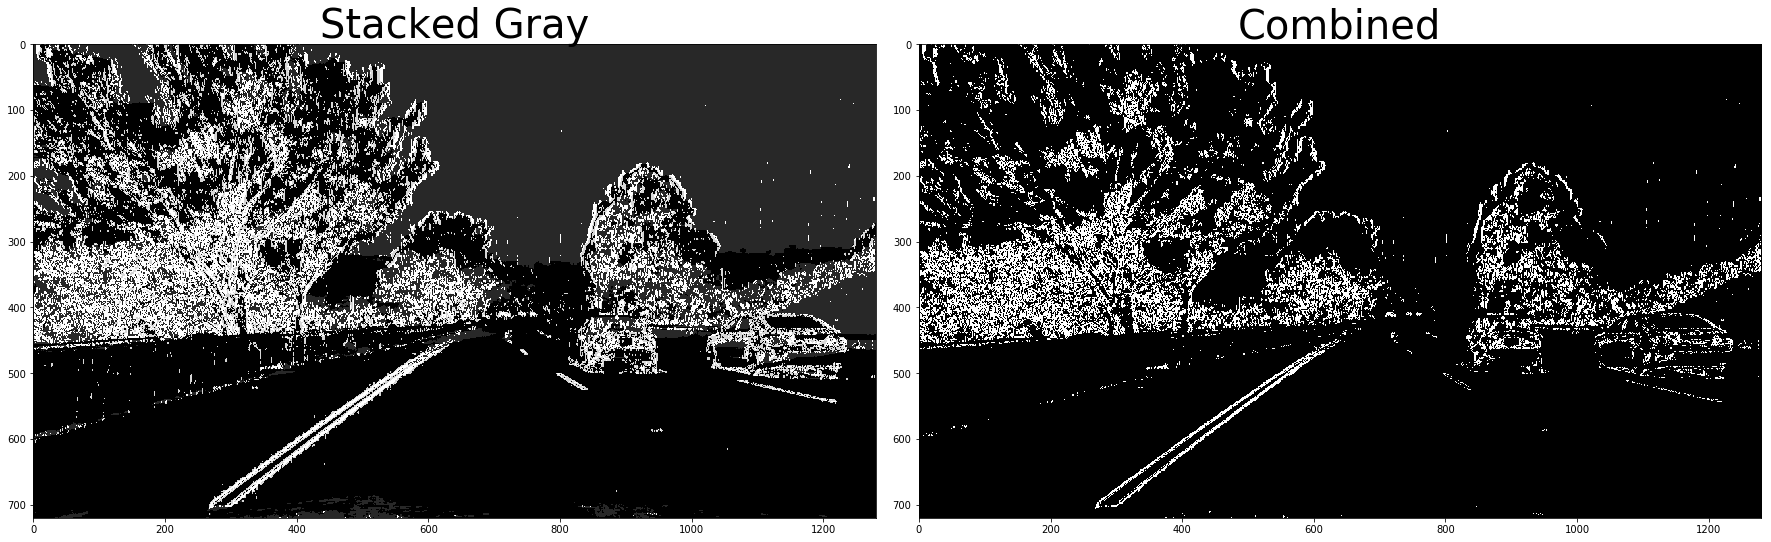

In [7]:

#Define the chanels
sxbinary=result[:,:,1]
scbinary=result[:,:,2]
combined_binary = np.zeros_like(sxbinary)
combined_binary[(scbinary == 255) & (sxbinary == 255)] = 1
gray=cv2.cvtColor(result, cv2.COLOR_RGB2GRAY)
# Plot stacked gray and combined
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(gray,cmap='gray')
ax1.set_title('Stacked Gray', fontsize=40)
ax2.imshow(combined_binary,cmap='gray')
ax2.set_title('Combined', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

#Save the images
plt.imsave('pipeline_images/stacked_gray.jpg', gray,cmap='gray')
plt.imsave('pipeline_images/combined_gray.jpg', combined_binary, cmap='gray')




Next, we use the "stacked gray" for our perspective transformation.

### 4. Perspective transform and filter



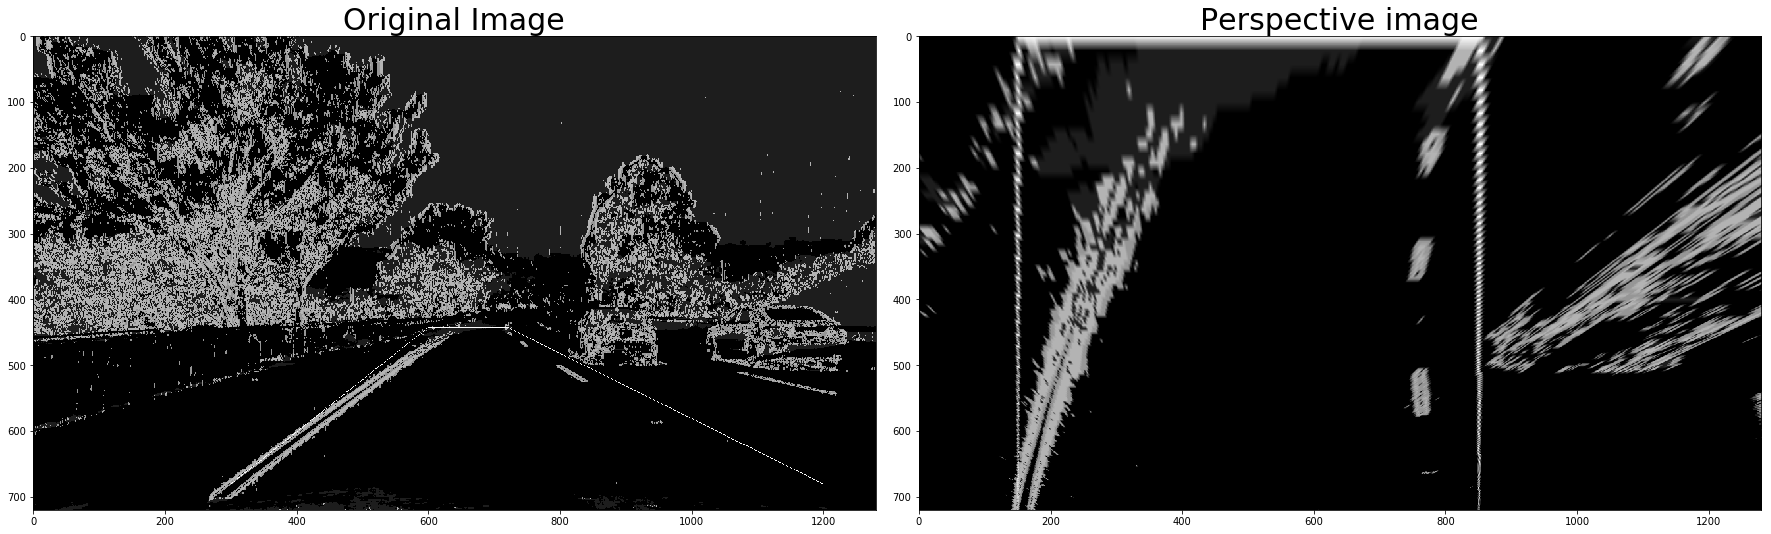

In [8]:
# Define the width and length of the output rectangle
x_l=700
y_l=720
#Define the polygon where search is to be performed
src=np.float32([[300,680],[600,442],[720,442],[1200,680]])
dst= np.float32([[150,y_l],[150,0],[150+x_l,0],[150+x_l,y_l]])

# Draw the polygon
line_1=cv2.line(gray,tuple(src[0]),tuple(src[1]),(255,0,0),1)
line_2=cv2.line(gray,tuple(src[1]),tuple(src[2]),(255,0,0),1)
line_3=cv2.line(gray,tuple(src[2]),tuple(src[3]),(255,0,0),1)
line_4=cv2.line(gray,tuple(src[3]),tuple(src[0]),(255,0,0),1)
# Get the transform matrix
M=cv2.getPerspectiveTransform(src,dst)
# Warp the image
warped=cv2.warpPerspective(gray,M,gray.shape[::-1],flags=cv2.INTER_LINEAR)
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(gray,cmap='gray')
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(warped,cmap='gray')
ax2.set_title('Perspective image', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

#Save the images
plt.imsave('pipeline_images/gray_to_scan.jpg', gray,cmap='gray')
plt.imsave('pipeline_images/gray_perspective.jpg', warped,cmap='gray')


We use the right-hand image to fit the polynomials to the lanes. However, we see the presence of outside elements that can lead the scanning algorithm to false positive identification. Thus, we define thresholds to remove the shadows and also every element outside the transformed scanning zone plus a safety margin.

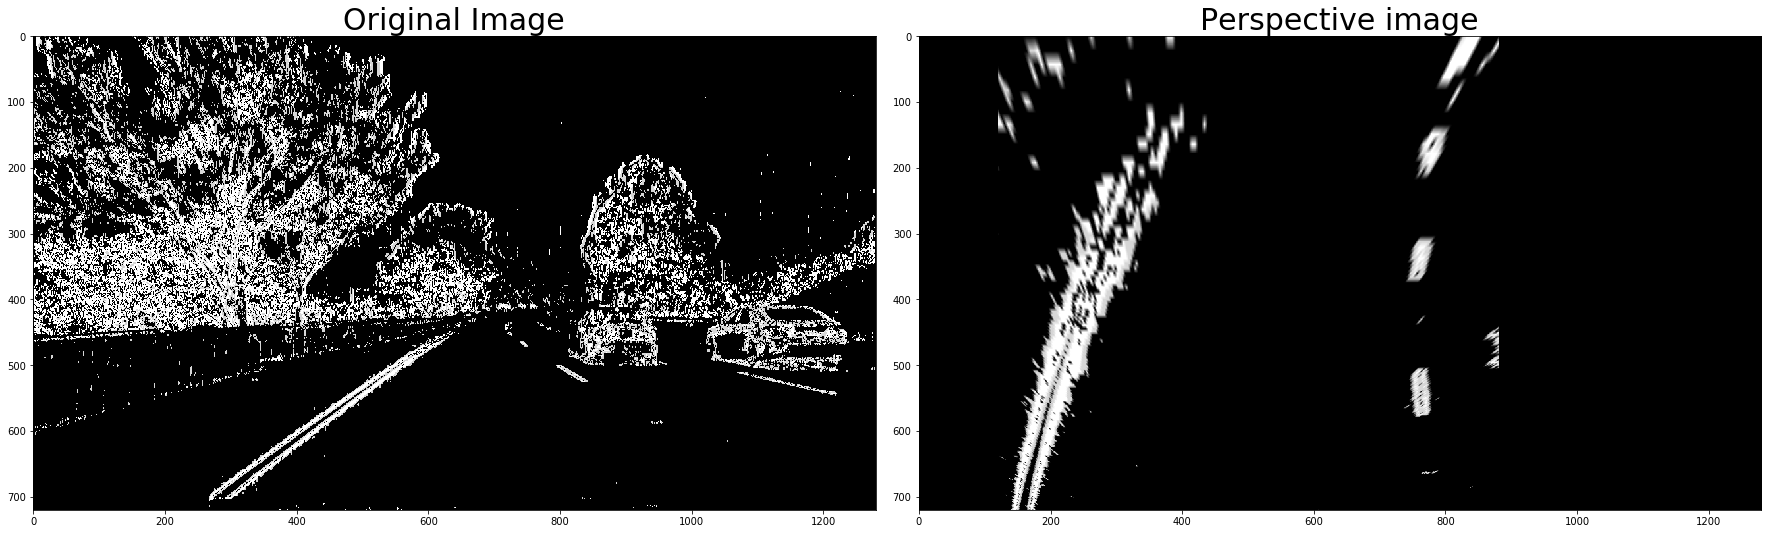

In [9]:
# Define a threshold
threshold=30
gray=cv2.cvtColor(result, cv2.COLOR_RGB2GRAY)
gray[gray<threshold]=0
# Get the transform matrix
M=cv2.getPerspectiveTransform(src,dst)
# Warp the image
warped_filter=cv2.warpPerspective(gray,M,gray.shape[::-1],flags=cv2.INTER_LINEAR)
# Set the values outside the rectangle plus a safety margin to zero
margin=30
warped_filter[:,:150-margin]=0
warped_filter[:,850+margin:]=0

#Plot the results
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(gray,cmap='gray')
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(warped_filter,cmap='gray')
ax2.set_title('Perspective image', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

plt.imsave('pipeline_images/gray_to_scan_filtered.jpg', gray,cmap='gray')
plt.imsave('pipeline_images/gray_perspective_filtered.jpg', warped_filter, cmap='gray')



### 5. Detect lane pixels and fit the polynomials
We use the function fit_polynomial defined in the auxilliary module. This function yields the fitted image, and the coefficients of both right and left fit. Moreover it filters everything that is not identified as lane pixels.


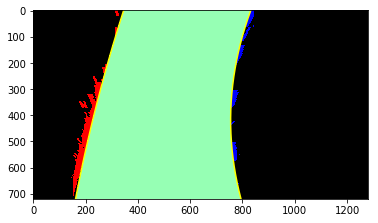

In [10]:
#Get the image again, and warp it
from aux_functions import fit_polynomial
gray_filter=cv2.cvtColor(result, cv2.COLOR_RGB2GRAY)
gray_filter[gray_filter<threshold]=0
warped_filter=cv2.warpPerspective(gray_filter,M,gray.shape[::-1],flags=cv2.INTER_LINEAR)
margin=30
warped_filter[:,:150-margin]=0
warped_filter[:,850+margin:]=0
leftx,rightx, lefty,righty, out_img=fit_polynomial(warped_filter)
plt.imshow(out_img)
#Save image
plt.imsave('pipeline_images/lanes_id_pol.jpg', out_img)



### 6. Determine the radio of curvature and the position of the vehicle position with respect to the center

The radius of curvature of the left lane is 1843.203029871856 m.
The radius of curvature of the right lane is 376.6014582697021 m.
The distance between the vehicle and the middle of the lane is 2.901857142857143 m


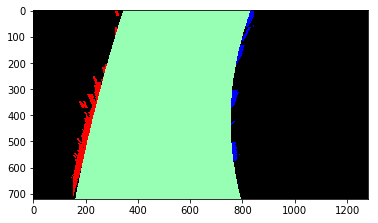

In [11]:
left_curverad, right_curverad,distance, out_img = measure_curvature_distance_real(out_img,leftx,rightx,lefty,righty,x_l,y_l)
print("The radius of curvature of the left lane is {} m.".format(left_curverad))
print("The radius of curvature of the right lane is {} m.".format(right_curverad))
print("The distance between the vehicle and the middle of the lane is {} m".format(distance))
plt.imshow(out_img)


### 7. Warp back the image

We apply the inverse perspective and overlay the result with the undistorted image.

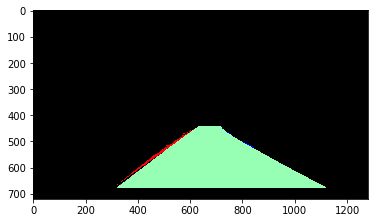

In [12]:
unwarped_back=cv2.warpPerspective(out_img,M,gray.shape[::-1],flags=cv2.WARP_INVERSE_MAP)
plt.imshow(unwarped_back)
plt.imsave('pipeline_images/warp_inverse.jpg', unwarped_back)



One can see that the detected pixels coincide with the lanes.We can overlay the image with the original chanel S to check the fit.

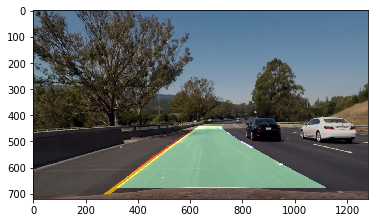

In [13]:
# Produce a weighted image
resulting=cv2.addWeighted(unwarped_back,0.5,image_test_und,0.8,0)
plt.imshow(resulting)
plt.imsave('pipeline_images/warped_inv_original_overlay.jpg', resulting)



The fit is good. 

### 8. Output visual display of the lanes, their curvature, and the vehicle position.

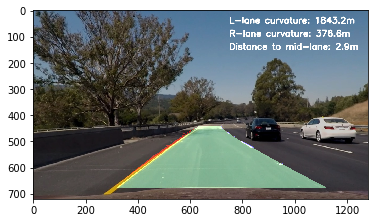

In [14]:
cv2.putText(resulting, "L-lane curvature: "+ str(round(left_curverad,1)) + "m", (750, 50), cv2.FONT_ITALIC, 1.1,  (255, 255, 255), thickness=3, lineType=cv2.LINE_AA)
cv2.putText(resulting, "R-lane curvature: "+ str(round(right_curverad,1)) + "m", (750, 100), cv2.FONT_ITALIC, 1.1,  (255, 255, 255), thickness=3, lineType=cv2.LINE_AA)
cv2.putText(resulting, "Distance to mid-lane: "+ str(round(distance,2)) + "m", (750, 150), cv2.FONT_ITALIC, 1.1,  (255, 255, 255), thickness=3, lineType=cv2.LINE_AA)
plt.imshow(resulting)
plt.imsave('pipeline_images/pipeline_output.jpg',resulting)



We are ready to move into the video pipeline.

### 9. Process the video


We start by defining a function incuding all the necessary steps to produce what we have done above.

In [19]:
def process_image(frame,threshold=30):
    image_test_und=cv2.undistort(frame,cameraMatrix,distCoeffs,None,cameraMatrix)
    result = pipeline_grad_color_thresh(image_test_und,s_thresh=(50, 180), sx_thresh=(10, 190))
    gray=cv2.cvtColor(result, cv2.COLOR_RGB2GRAY)
    gray[gray<threshold]=0
    warped=cv2.warpPerspective(gray,M,gray.shape[::-1],flags=cv2.INTER_LINEAR)
    warped[:,:150-30]=0
    warped[:,850+30:]=0
    leftx,rightx,lefty,righty,out_img=fit_polynomial(warped,video=True)
    left_curverad, right_curverad,distance, out_img_1 = measure_curvature_distance_real(out_img,leftx,rightx,lefty,righty,x_l,y_l)
    unwarped_back=cv2.warpPerspective(out_img_1,M,gray.shape[::-1],flags=cv2.WARP_INVERSE_MAP)
    # Produce a weighted image
    resulting=cv2.addWeighted(unwarped_back,0.5,image_test_und,0.8,0)
    cv2.putText(resulting, "L-lane curvature: "+ str(round(left_curverad,1)) + "m", (750, 50), cv2.FONT_ITALIC, 1.1,  (255, 255, 255), thickness=3, lineType=cv2.LINE_AA)
    cv2.putText(resulting, "R-lane curvature: "+ str(round(right_curverad,1)) + "m", (750, 100), cv2.FONT_ITALIC, 1.1,  (255, 255, 255), thickness=3, lineType=cv2.LINE_AA)
    cv2.putText(resulting, "Distance to mid-lane: "+ str(round(distance,2)) + "m", (750, 150), cv2.FONT_ITALIC, 1.1,  (255, 255, 255), thickness=3, lineType=cv2.LINE_AA)
    return resulting    

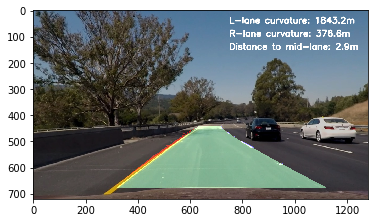

In [20]:
# Test the image processor
a=process_image(image_test)
plt.imshow(a)

In [21]:
from moviepy.editor import *
from IPython.display import HTML

In [22]:
white_output = 'project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)


[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [08:01<00:00,  2.38it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 12min 47s, sys: 29.7 s, total: 13min 17s
Wall time: 8min 3s


In [23]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

Below, you can find my attempt to identify the lanes in the challenge video.

In [55]:
def process_image(frame,threshold=30):
    image_test_und=cv2.undistort(frame,cameraMatrix,distCoeffs,None,cameraMatrix)
    result = pipeline_grad_color_thresh(image_test_und,s_thresh=(50, 180), sx_thresh=(10, 190))
    gray=cv2.cvtColor(result, cv2.COLOR_RGB2GRAY)
    gray[gray<threshold]=0
    warped=cv2.warpPerspective(gray,M,gray.shape[::-1],flags=cv2.INTER_LINEAR)
    warped[:,:150-30]=0
    warped[:,850+30:]=0
    left_fit,right_fit,out_img=fit_polynomial(warped,video=True, left_fit, right_fit)
    left_curverad, right_curverad,distance, out_img_1 = measure_curvature_distance_real(out_img,left_fit,right_fit,x_l,y_l)
    unwarped_back=cv2.warpPerspective(out_img_1,M,gray.shape[::-1],flags=cv2.WARP_INVERSE_MAP)
    # Produce a weighted image
    resulting=cv2.addWeighted(unwarped_back,0.5,image_test_und,0.8,0)
    cv2.putText(resulting, "L-lane curvature: "+ str(round(left_curverad,1)) + "m", (750, 50), cv2.FONT_ITALIC, 1.1,  (255, 255, 255), thickness=3, lineType=cv2.LINE_AA)
    cv2.putText(resulting, "R-lane curvature: "+ str(round(right_curverad,1)) + "m", (750, 100), cv2.FONT_ITALIC, 1.1,  (255, 255, 255), thickness=3, lineType=cv2.LINE_AA)
    cv2.putText(resulting, "Distance to mid-lane: "+ str(round(distance,2)) + "m", (750, 150), cv2.FONT_ITALIC, 1.1,  (255, 255, 255), thickness=3, lineType=cv2.LINE_AA)
    return resulting    



 74%|███████▍  | 931/1260 [00:50<00:16, 20.21it/s]

In [173]:
def fit_poly(img_shape, leftx, lefty, rightx, righty):
    left_fit = np.polyfit(lefty,leftx,2)
    right_fit = np.polyfit(righty,rightx,2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2+left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2+right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, left_fit, right_fit, ploty


def search_around_poly(binary_warped,left_fit, right_fit):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 200

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###

    left_fitx = left_fit[0]*nonzeroy**2+left_fit[1]*nonzeroy + left_fit[2]
    right_fitx = right_fit[0]*nonzeroy**2+right_fit[1]*nonzeroy + right_fit[2]
    left_lane_inds= ((nonzerox >= left_fitx-margin) &  (nonzerox < left_fitx+margin)).nonzero()
    right_lane_inds= ((nonzerox >= right_fitx-margin) &  (nonzerox < right_fitx+margin)).nonzero()

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty=nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty=nonzeroy[right_lane_inds]
    
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    out_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Fit new polynomials
    left_fitx, right_fitx, left_fit, right_fit, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    
    
    return left_fitx, right_fitx,left_fit, right_fit, ploty,out_img

def fit_or_search(binary_warped,left_fit_p,right_fit_p,video=False):
    if len(left_fit_p)*len(right_fit_p)==0:
        # Perform blind search
        t0=time
        leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        
        # Color in left and right line pixels
        out_img[lefty, leftx] = [255, 0, 0]
        out_img[righty, rightx] = [0, 0, 255]
        left_fitx, right_fitx, left_fit, right_fit, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    else :
        #print("No Blind")
        left_fitx, right_fitx, left_fit, right_fit, ploty,out_img= search_around_poly(binary_warped,left_fit_p,right_fit_p)
    ## Visualization ##
   
    if video==False:
        plt.plot(left_fitx,ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
    #Draw the rectangle between the lanes
    left_p=np.array(list(zip(left_fitx,ploty))).astype(np.int32)
    right_p=np.array(list(zip(right_fitx,ploty))).astype(np.int32)
    right_p=np.flipud(right_p)
    p=np.concatenate((left_p, right_p))
    cv2.fillPoly(out_img, [p], color=[150,255,180])
    return left_fit, right_fit, out_img

In [174]:

def process_image_1(frame, left_fit=None, right_fit=None, threshold=30):
    image_test_und=cv2.undistort(frame,cameraMatrix,distCoeffs,None,cameraMatrix)
    result = pipeline_grad_color_thresh(image_test_und,s_thresh=(50, 180), sx_thresh=(10, 190))
    gray=cv2.cvtColor(result, cv2.COLOR_RGB2GRAY)
    gray[gray<threshold]=0
    warped=cv2.warpPerspective(gray,M,gray.shape[::-1],flags=cv2.INTER_LINEAR)
    warped[:,:150-30]=0
    warped[:,850+30:]=0
    left_fit_1,right_fit_1,out_img=fit_or_search(warped,left_fit,right_fit,video=True)
    left_curverad, right_curverad,distance, out_img_1 = measure_curvature_distance_real(out_img,left_fit_1,right_fit_1,x_l,y_l)
    unwarped_back=cv2.warpPerspective(out_img_1,M,gray.shape[::-1],flags=cv2.WARP_INVERSE_MAP)
    # Produce a weighted image
    resulting=cv2.addWeighted(unwarped_back,0.5,image_test_und,0.8,0)
    cv2.putText(resulting, "L-lane curvature: "+ str(round(left_curverad,1)) + "m", (750, 50), cv2.FONT_ITALIC, 1.1,  (255, 255, 255), thickness=3, lineType=cv2.LINE_AA)
    cv2.putText(resulting, "R-lane curvature: "+ str(round(right_curverad,1)) + "m", (750, 100), cv2.FONT_ITALIC, 1.1,  (255, 255, 255), thickness=3, lineType=cv2.LINE_AA)
    cv2.putText(resulting, "Distance to mid-lane: "+ str(round(distance,2)) + "m", (750, 150), cv2.FONT_ITALIC, 1.1,  (255, 255, 255), thickness=3, lineType=cv2.LINE_AA)
    return resulting, left_fit_1, right_fit_1

In [177]:

import time
clip1 = VideoFileClip("challenge_video.mp4")
t0 = time.time()
list_frames =list(clip1.iter_frames())
left_fit=[]
right_fit=[]
for i in range(len(list_frames)):
    #print(left_fit,right_fit)
    list_frames[i], left_fit, right_fit =process_image_1(list_frames[i], left_fit, right_fit)
t1 = time.time()
print("{}s".format(t1-t0))


151.51572608947754s


In [178]:
new_clip = ImageSequenceClip(list_frames, fps=clip1.fps)
test_challenge='test_challenge.mp4'
%time new_clip.write_videofile(test_name,audio=False)

[MoviePy] >>>> Building video test_challenge.mp4
[MoviePy] Writing video test_challenge.mp4




  0%|          | 0/485 [00:00<?, ?it/s]

  2%|▏         | 8/485 [00:00<00:06, 78.24it/s]

  5%|▍         | 22/485 [00:00<00:05, 90.09it/s]

  7%|▋         | 36/485 [00:00<00:04, 100.35it/s]

 10%|▉         | 47/485 [00:00<00:06, 62.96it/s] 

 11%|█         | 54/485 [00:00<00:09, 47.23it/s]

 12%|█▏        | 60/485 [00:01<00:10, 40.33it/s]

 13%|█▎        | 65/485 [00:01<00:12, 33.41it/s]

 14%|█▍        | 70/485 [00:01<00:13, 31.48it/s]

 15%|█▌        | 74/485 [00:01<00:13, 31.17it/s]

 16%|█▌        | 78/485 [00:01<00:13, 29.64it/s]

 17%|█▋        | 82/485 [00:01<00:14, 27.45it/s]

 18%|█▊        | 85/485 [00:02<00:15, 26.30it/s]

 18%|█▊        | 89/485 [00:02<00:15, 25.20it/s]

 19%|█▉        | 93/485 [00:02<00:15, 25.30it/s]

 20%|██        | 97/485 [00:02<00:16, 23.51it/s]

 21%|██        | 101/485 [00:02<00:15, 24.56it/s]

 22%|██▏       | 105/485 [00:02<00:15, 24.12it/s]

 22%|██▏       | 109/485 [00:03<00:17, 21.85it/s]

 23%|██▎       | 113/485 [00:03<00:16, 22.62it/s]

 2

[MoviePy] Done.
[MoviePy] >>>> Video ready: test_challenge.mp4 

CPU times: user 918 ms, sys: 547 ms, total: 1.46 s
Wall time: 19.7 s


In [179]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(test_challenge))

One can see that the presence of the bridge confounds the algorithm and breaks the identification. Further improvements should be attempted.